# Clustering

## Load Files

In [6]:
from goodreads_shelves import get_shelves_given_titles
from preprocessor import PreProcessor
from library import Library
from os.path import isfile
from tqdm import tqdm
import pickle,time

TITLES = '../data/base/books.txt'
SHELVES = '../data/base/book_shelves.json'

DELIM = '../data/base/books_delimiter_data.txt'
RAW = '../data/raw'

DICT = '../data/dumps/book_dictionary.dict'
CORP = '../data/dumps/book_corpus.dict'
TOKEN = '../data/dumps/token_dump.p'

LDA_MODEL = '../data/dumps/lda_model.p'
LSI_MODEL = '../data/dumps/lsi_model.p'

## Baseline

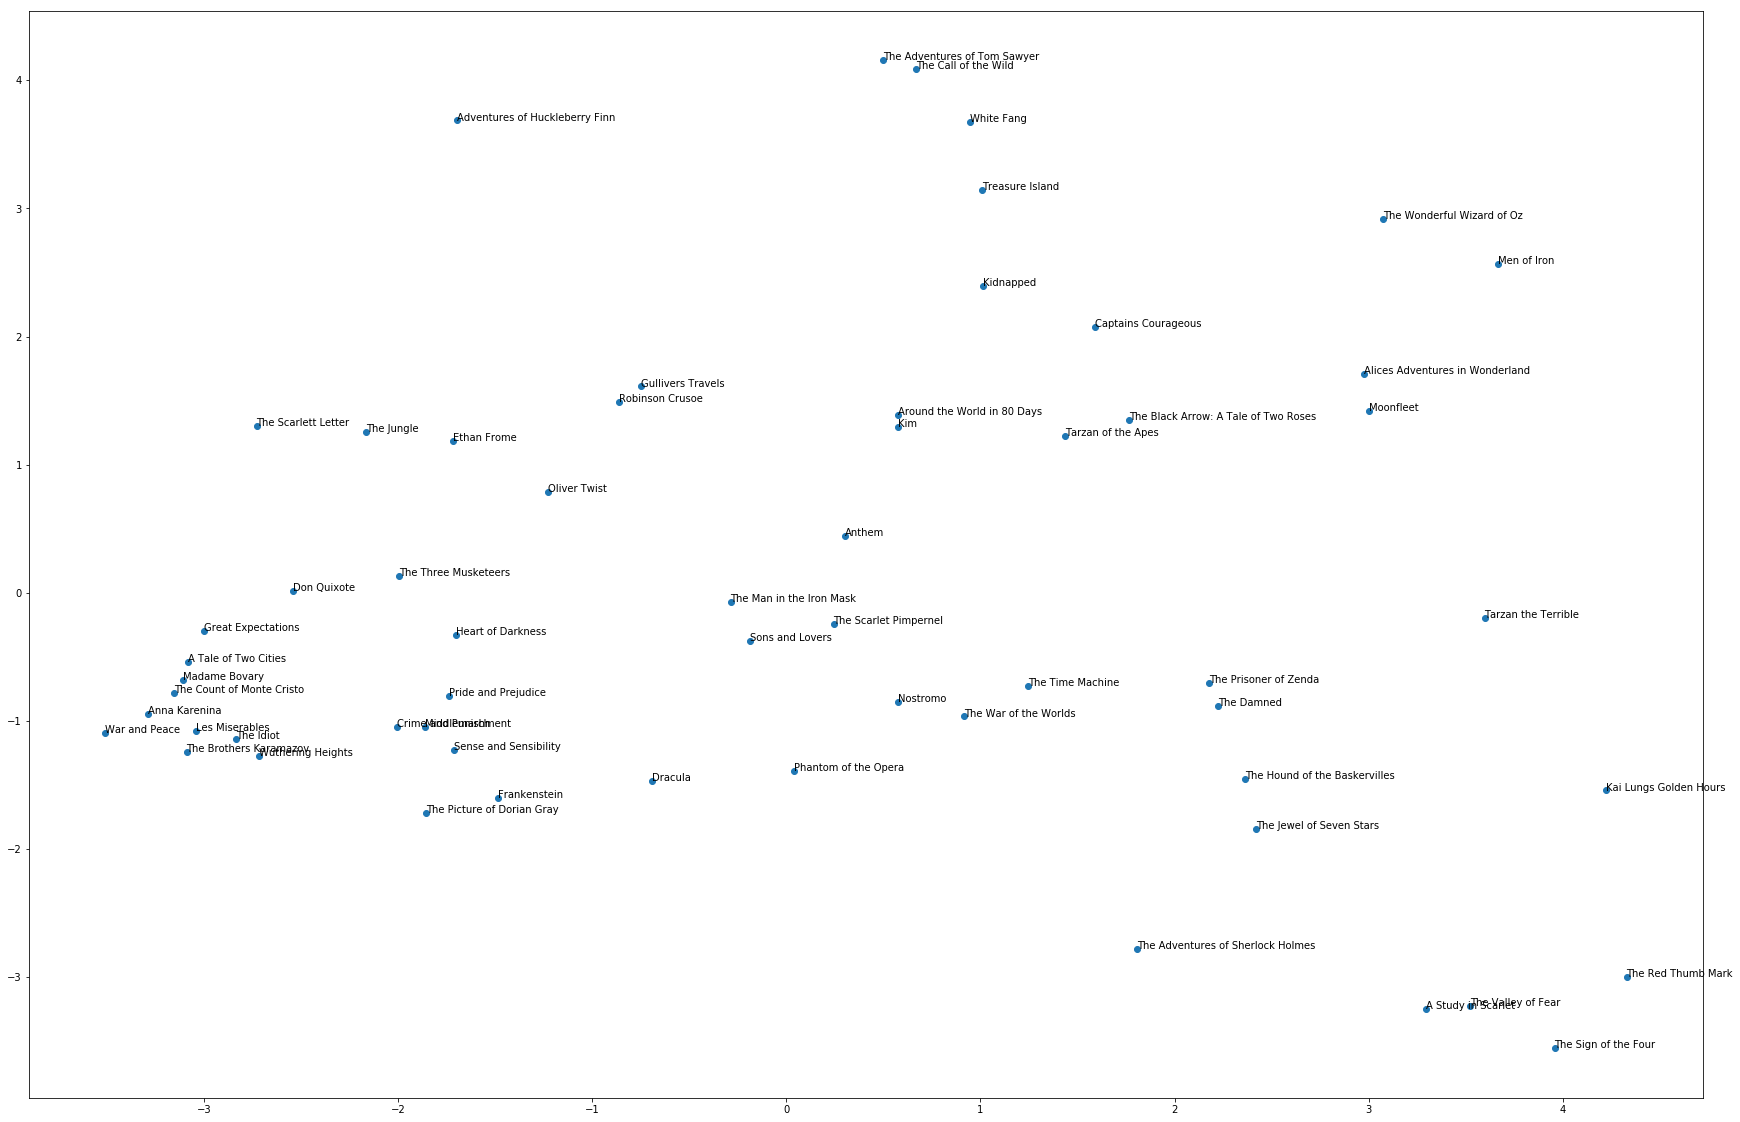

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import json

baseline_book_vectors = json.load(open(SHELVES, 'r'))
baseline_book_vectors = {title: baseline_book_vectors[title] for title in baseline_book_vectors if len(baseline_book_vectors[title]) != 0}
del(baseline_book_vectors['The Merry Adventures of Robin Hood'])

vocab = []
for title in baseline_book_vectors:
    vocab += baseline_book_vectors[title]

vocab = enumerate(list(set(vocab)))
vocab_dict = { pair[1]: pair[0] for pair in vocab }

pca = PCA(n_components=2)

book_matrix = []
titles = []
for title in baseline_book_vectors:
    book_vector = np.zeros(len(vocab_dict)) 
    for word in baseline_book_vectors[title]:
        book_vector[vocab_dict[word]] += 1
    titles.append(title)
    book_matrix.append(book_vector)
    
book_matrix = np.array(book_matrix)
pca_books = np.array([book for book in pca.fit_transform(book_matrix)])

x, y = zip(*pca_books)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(pca_books, np.zeros(len(x)))
neighbors = [book for book in knn.kneighbors(pca_books, n_neighbors=5)[1]]

base_neighbor_names = {} 
for group in neighbors:
    base_neighbor_names[titles[group[0]]] = [titles[j] for j in group[1:]]
    
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

ax.scatter(x, y)
for i in range(len(x)):
    ax.annotate(titles[i], (x[i],y[i])) 

fig.title('Base Clusters')
plt.show()

## LDA

0.15833333333333333
Time: 0.8525903224945068s


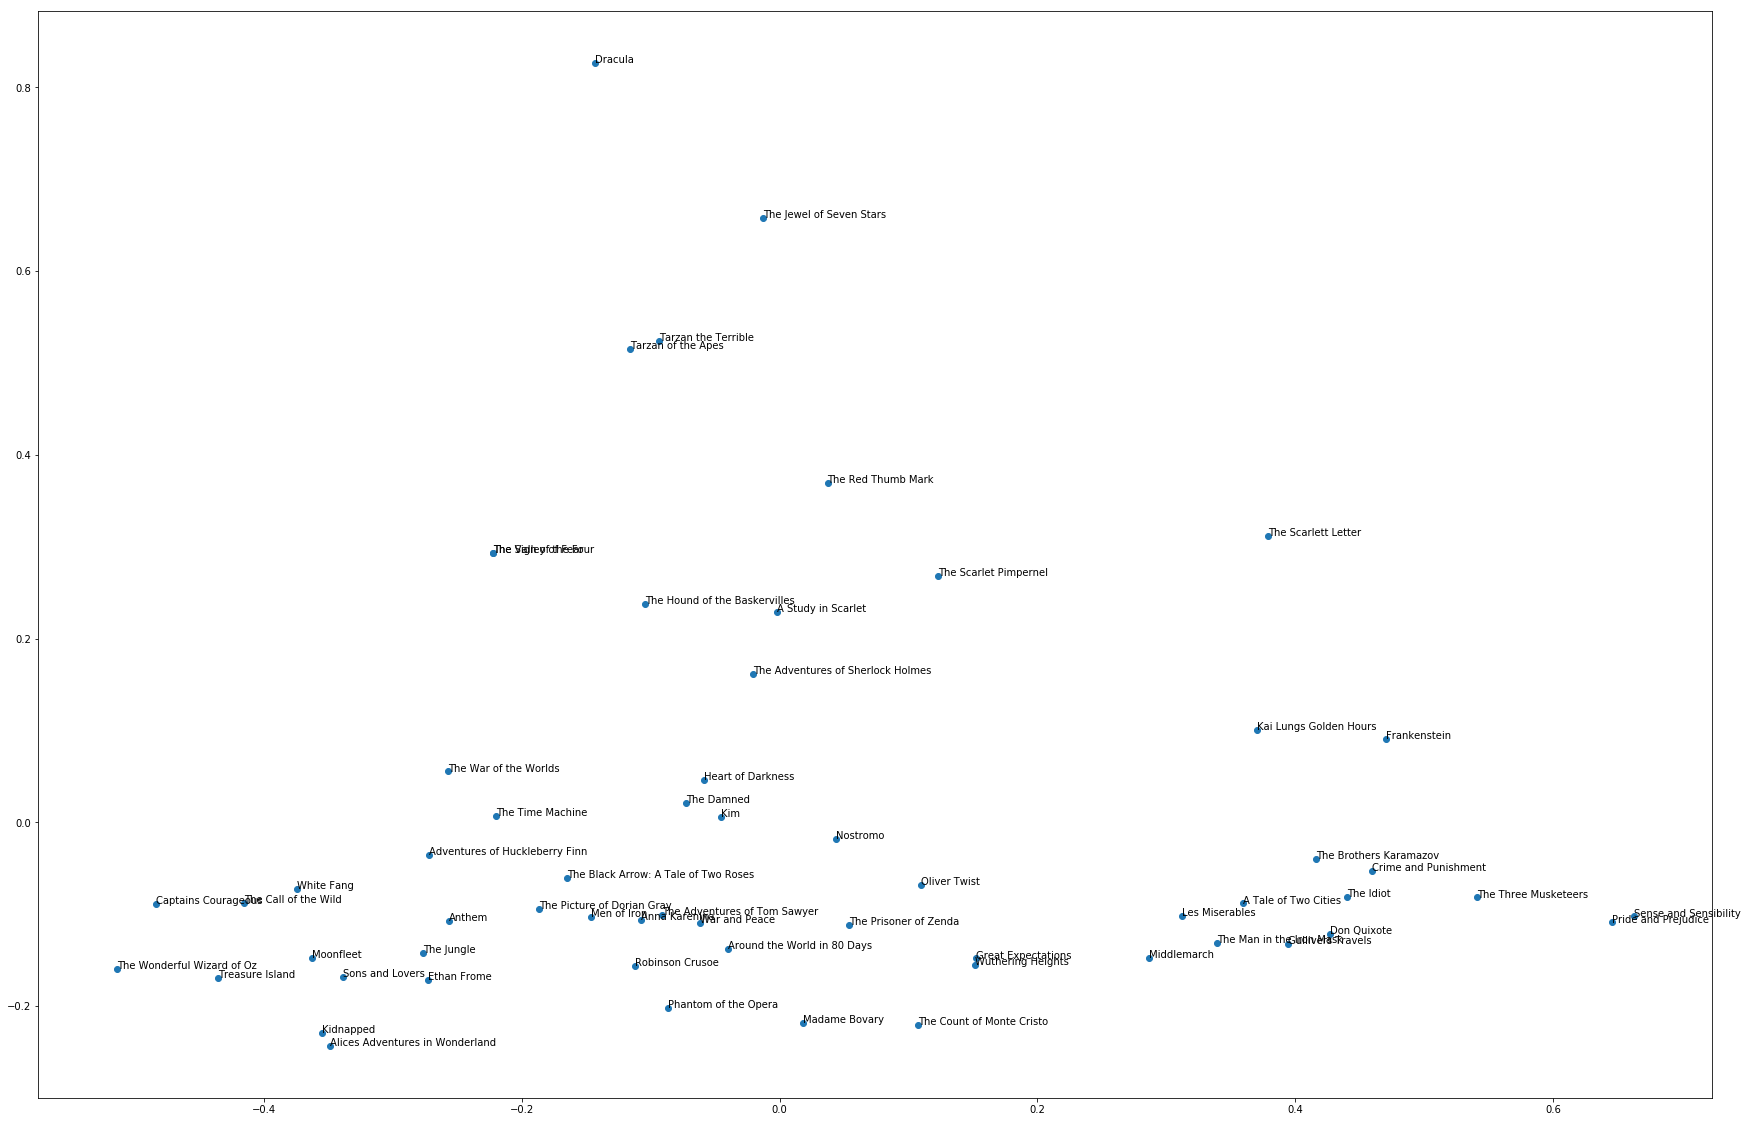

In [11]:
# Get book texts split into chapters
preprocessor = PreProcessor(DICT, CORP, DELIM, RAW, TOKEN, min_count = 10, headword_removal_perc = 0.05)
dictionary, corpus, books = preprocessor.get_library_info()

start_time = time.time()
if not isfile(LDA_MODEL):
    lda = Library(dictionary, corpus, num_topics = 50, chunksize=2, model_type = 'LDA', passes=5)
    for title in tqdm(books):
        lda.add_book(books[title])

    pickle.dump(lda, open(LDA_MODEL, 'wb'))
else:
    lda = pickle.load(open(LDA_MODEL, 'rb'))
    
lda.model.print_topics()
    
pca = PCA(n_components=2) 

book_vectors = []
titles = []
for title in books:
    vector = np.zeros(5000)
    book = lda.model[dictionary.doc2bow(books[title]['book_tokens'])]
    for pair in book:
        vector[pair[0]] = pair[1]
    titles.append(title)
    book_vectors.append(vector)

book_matrix = np.array(book_vectors)
pca_books = np.array([book for book in pca.fit_transform(book_matrix)])

x, y = zip(*pca_books)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(pca_books, np.zeros(len(x)))
neighbors = [book for book in knn.kneighbors(pca_books, n_neighbors=5)[1]]

neighbor_names = {} 
for group in neighbors:
    neighbor_names[titles[group[0]]] = [titles[j] for j in group[1:]]
      
total_count = 0
for title in neighbor_names:
    count = 0
    for base_title in base_neighbor_names[title]:
        if base_title in neighbor_names[title]:
            count += 1
    total_count += count

print(total_count/(len(neighbor_names)*4))
print('Time: %ss' % (time.time() - start_time))
    
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

ax.scatter(x, y)
for i in range(len(x)):
    ax.annotate(titles[i], (x[i],y[i])) 

plt.show()

## LSI

In [ ]:
from tqdm import tqdm_notebook as tqdm

# Get book texts split into chapters
preprocessor = PreProcessor(DICT, CORP, DELIM, RAW, TOKEN, min_count = 10, headword_removal_perc = 0.05)
dictionary, corpus, books = preprocessor.get_library_info()

if not isfile(LSI_MODEL):
    lsi = Library(dictionary, corpus, num_topics = 50, chunksize=10, model_type = 'LSI')
    for title in tqdm(books):
        lsi.add_book(books[title])

    pickle.dump(lsi, open(LSI_MODEL, 'wb'))
else:
    lsi = pickle.load(open(LSI_MODEL, 'rb'))
    
    
pca = PCA(n_components=2) 
    
book_vectors = []
titles = []
for title in books:
    vector = np.zeros(50)
    book = lsi.model[dictionary.doc2bow(books[title]['book_tokens'])]
    for pair in book:
        vector[pair[0]] = pair[1]
    titles.append(title)
    book_vectors.append(vector)

book_matrix = np.array(book_vectors)
pca_books = np.array([book for book in pca.fit_transform(book_matrix)])

x, y = zip(*pca_books)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(pca_books, np.zeros(len(x)))
neighbors = [book for book in knn.kneighbors(pca_books, n_neighbors=5)[1]]

neighbor_names = {} 
for group in neighbors:
    neighbor_names[titles[group[0]]] = [titles[j] for j in group[1:]]
      
total_count = 0
for title in neighbor_names:
    count = 0
    for base_title in base_neighbor_names[title]:
        if base_title in neighbor_names[title]:
            count += 1
    total_count += count
            
print(total_count/(len(neighbor_names)*4))

# fig, ax = plt.subplots(1, 1, figsize=(30, 30))
# 
# ax.scatter(x, y)
# for i in range(len(x)):
#     ax.annotate(titles[i], (x[i],y[i])) 
# 
# plt.show()

## Method

Extracting Topics: 100%|██████████| 20000/20000 [00:07<00:00, 2620.18it/s]


0.1271186440677966
Time: 277.8595016002655s


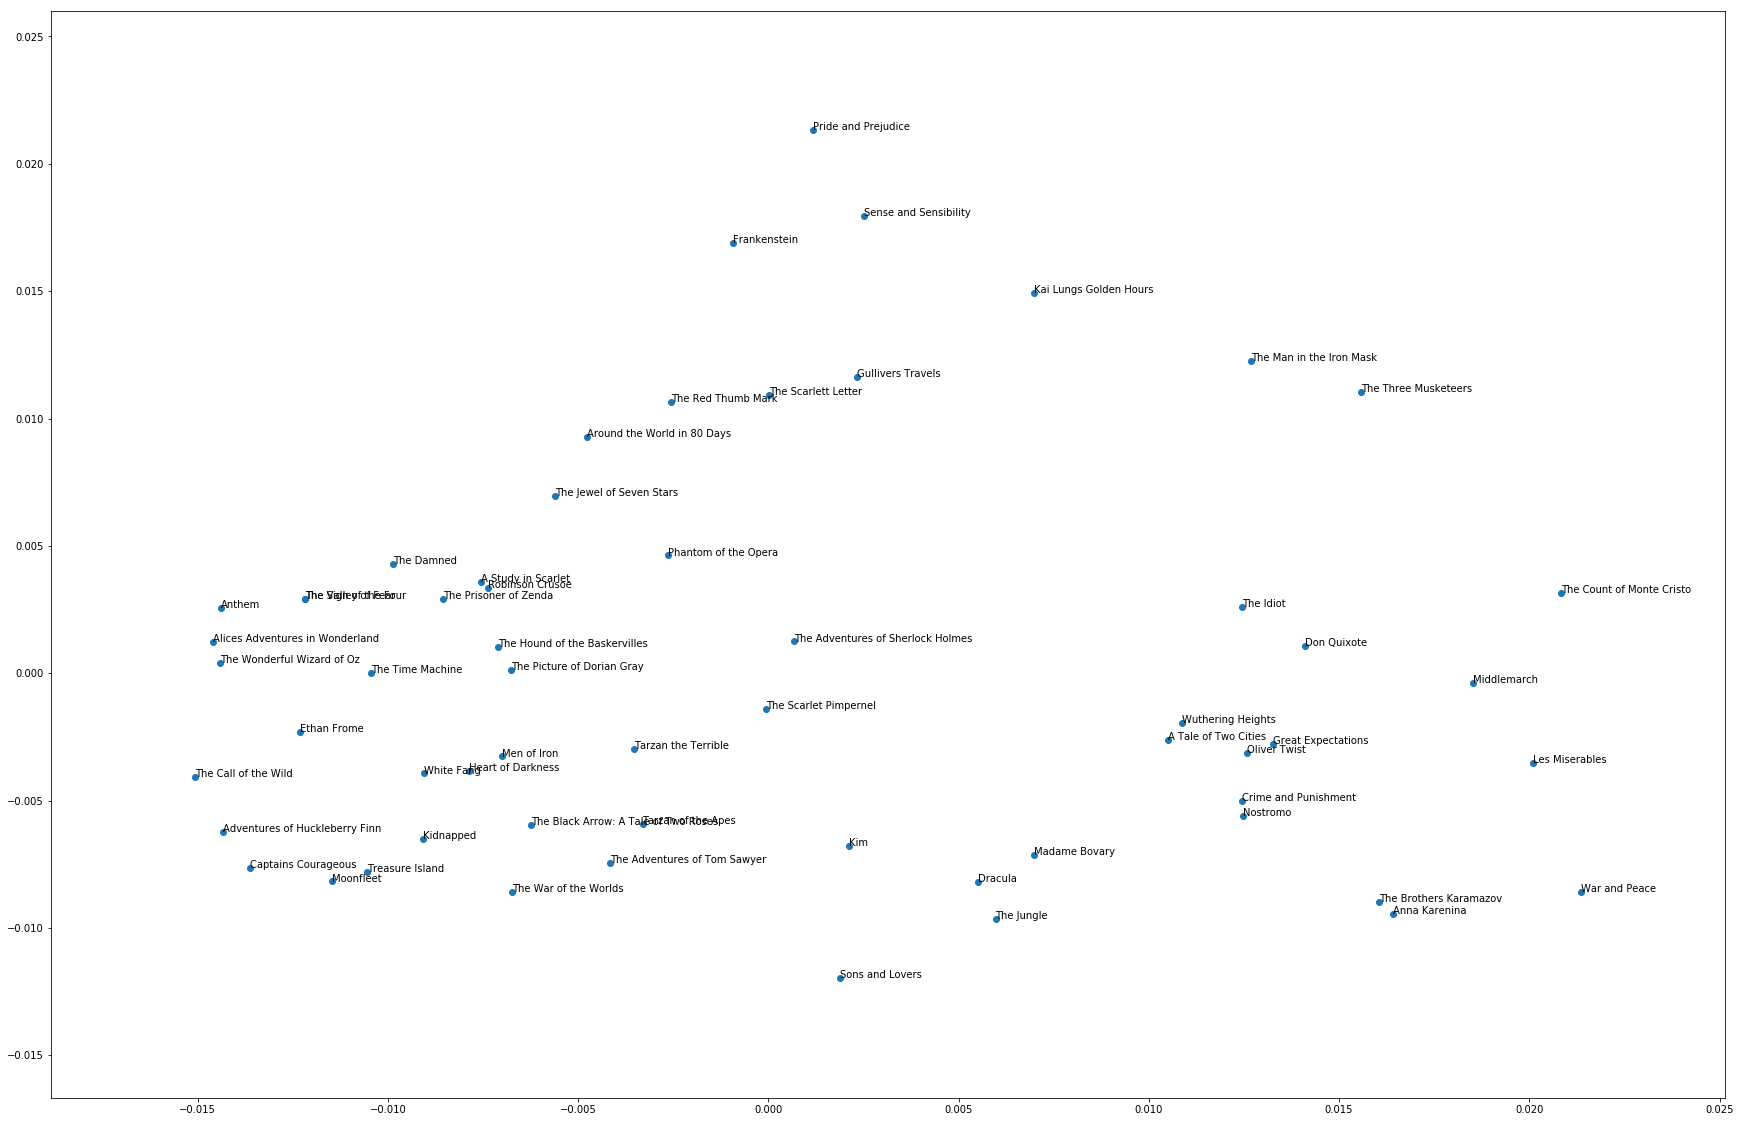

In [13]:
from topic_model import TopicModel

preprocessor = PreProcessor(DICT, CORP, DELIM, RAW, TOKEN, min_count = 10, headword_removal_perc = 0.05)
dictionary, corpus, books = preprocessor.get_library_info()

books = [(book, books[book]['book_tokens']) for book in books]
titles, books = zip(*books)

start_time = time.time()
tm = TopicModel(20000, 10, 1.0)
tm.add_documents(books)
y_axes = tm.gen_y_axes()
topic_freqs, book_topics = tm.calc_trigram_topics(books, y_axes)

sorted_topics = [(topic, topic_freqs[topic]) for topic in topic_freqs]
sorted_topics = sorted(sorted_topics, key=lambda x: x[1], reverse=True)
top_percent_count = int(len(sorted_topics) * .05)
sorted_topics = sorted_topics[top_percent_count:top_percent_count + 2000] 

# for topic in sorted_topics[:210]:print(topic)

book_vectors = []
for book_index in range(len(book_topics)):
    book_vector = np.zeros(len(sorted_topics))

    for topic_index in range(len(sorted_topics)):
        topic = sorted_topics[topic_index][0]

        if topic in book_topics[book_index]:
            book_vector[topic_index] = np.average(book_topics[book_index][topic])

    book_vector_total = np.sum(book_vector)
    book_vector = [point/book_vector_total for point in book_vector]
    book_vectors.append(book_vector)
    
book_matrix = np.array(book_vectors)
pca_books = np.array([book for book in pca.fit_transform(book_matrix)])

x, y = zip(*pca_books)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(pca_books, np.zeros(len(x)))
neighbors = [book for book in knn.kneighbors(pca_books, n_neighbors=5)[1]]

neighbor_names = {} 
for group in neighbors:
    neighbor_names[titles[group[0]]] = [titles[j] for j in group[1:]]
      
total_count = 0
for title in neighbor_names:
    count = 0
    for base_title in base_neighbor_names[title]:
        if base_title in neighbor_names[title]:
            count += 1
    total_count += count
    
print(total_count/(len(neighbor_names)*4))
print('Time: %ss' % (time.time() - start_time))
    
fig, ax = plt.subplots(1, 1, figsize=(30, 20))

ax.scatter(x, y)
for i in range(len(x)):
    ax.annotate(titles[i], (x[i],y[i])) 

plt.show()